# Investigation Dataset

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [148]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
data_root = './drive/MyDrive/ml-plus-msg/raw_data'

In [150]:
!ls ./drive/MyDrive/ml-plus-msg/raw_data/'Traffic, Investigations _ Other'/

crimes.csv			     police_districts.csv
hourly_weather_philadelphia.csv      police_stations.csv
investigations.csv		     traffic_stops_philadelphia.csv
philadelphia_population_metrics.csv


In [151]:
path = data_root + '/Traffic, Investigations _ Other/' + 'investigations' + '.csv'
df = pd.read_csv(path, parse_dates = ['datetimeoccur'])

In [152]:
df.columns

Index(['id', 'datetimeoccur', 'weekday', 'location', 'districtoccur', 'psa',
       'stoptype', 'inside_or_outside', 'gender', 'race', 'age',
       'individual_frisked', 'individual_searched', 'individual_arrested',
       'individual_contraband', 'vehicle_frisked', 'vehicle_searched',
       'vehicle_contraband', 'lat', 'lng', 'fips'],
      dtype='object')

In [153]:
df.isna().sum()
# missing values mainly in the location, and a few for age and gender

id                            0
datetimeoccur                 0
weekday                       0
location                      0
districtoccur                 0
psa                           0
stoptype                      0
inside_or_outside             0
gender                      775
race                          0
age                        4237
individual_frisked            0
individual_searched           0
individual_arrested           0
individual_contraband         0
vehicle_frisked               0
vehicle_searched              0
vehicle_contraband            0
lat                      483214
lng                      483214
fips                     488635
dtype: int64

In [154]:
df = df.dropna()
df.head(1)

,id,datetimeoccur,weekday,location,districtoccur,psa,stoptype,inside_or_outside,gender,race,...,individual_frisked,individual_searched,individual_arrested,individual_contraband,vehicle_frisked,vehicle_searched,vehicle_contraband,lat,lng,fips
0,1767776,2014-05-14 00:00:00+00:00,TUESDAY,300 BLOCK S 13TH ST,6,3,pedestrian,Outside,Male,Black - Non-Latino,...,0,0,0,0,0,0,0,39.946671,-75.162656,4.210100e+11


In [155]:
# now deal with categories
nominal = ['race', 'stoptype', 'inside_or_outside', 'gender']

numerical = ['age']
binary = ['individual_frisked', 'individual_searched', 'individual_arrested',
          'individual_contraband', 'vehicle_frisked', 'vehicle_searched', 'vehicle_contraband',]
time = ['datetimeoccur']
metadata = ['districtoccur','psa','lat','lng','fips']

In [156]:
data = pd.get_dummies(df, prefix="", prefix_sep="", columns = nominal, dtype = int)

map = {'Black - Non-Latino':'Black', 'White - Non-Latino':'White'}
data = data.rename(mapper=map, axis=1)
data.columns

Index(['id', 'datetimeoccur', 'weekday', 'location', 'districtoccur', 'psa',
       'age', 'individual_frisked', 'individual_searched',
       'individual_arrested', 'individual_contraband', 'vehicle_frisked',
       'vehicle_searched', 'vehicle_contraband', 'lat', 'lng', 'fips',
       'American Indian', 'Asian', 'Black - Latino', 'Black', 'Unknown',
       'White - Latino', 'White', 'pedestrian', 'vehicle', 'Inside', 'Outside',
       'Female', 'Male'],
      dtype='object')

I think official Phil gov uses hispanic <=> latino interchangebly (this corresponds with official data [here](https://philadelphiapublichealth.shinyapps.io/philastats/) and Alex's data)

We keep the following:
- race_Black NL
- race_White NL
- race_Asian


Race of investigation profile does not match race in population metrics,  thus we need to merge:
- race_Other = race_Indian American + race_unknown
- Hispanic = race_Black Latino/Hispanic + race_White Latino/Hispanic

In [157]:
data['Hispanic'] = data['Black - Latino'] + data['White - Latino']
data['Other'] = data['American Indian'] + data['Unknown']

data = data.drop(columns=['Black - Latino', 'White - Latino', 'American Indian', 'Unknown'])

### Big picture

In [158]:
data['datetimeoccur'].dt.date

0          2014-05-14
1          2014-05-14
2          2014-09-26
3          2014-02-26
4          2014-08-29
              ...    
2785073    2023-02-18
2785074    2023-02-15
2785075    2023-02-17
2785076    2023-02-14
2785085    2023-02-17
Name: datetimeoccur, Length: 2292414, dtype: object

In [159]:
tmp_df = pd.DataFrame(data['datetimeoccur'].dt.date)
tmp_df.rename(columns={'datetimeoccur':'date'}, inplace=True)

In [160]:
tmp_df.groupby('date').count().reset_index()

,date
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05
...,...
3331,2023-02-14
3332,2023-02-15
3333,2023-02-16
3334,2023-02-17


Text(0, 0.5, 'No. Investigations')

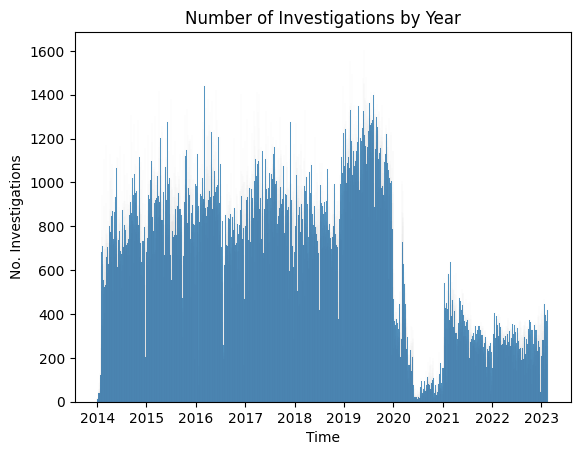

In [161]:
# fig, ax = plt.subplots()
# fig = px.line(tmp_df, x='date', y='traffic_stops', color='year')

ax = sns.histplot(data['datetimeoccur'].dt.date)
ax.set_title('Number of Investigations by Year')
ax.set_xlabel('Time')
ax.set_ylabel('No. Investigations')
# not suprisingly we see a sharp fall of investigation during pandemic time
# however, the number of investigation is less than previous years

Text(0.5, 0, 'Time of Day')

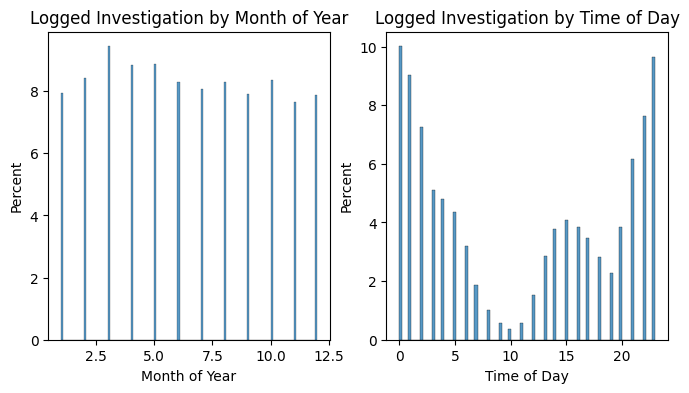

In [162]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0] = sns.histplot(data['datetimeoccur'].dt.month, stat='percent', ax=ax[0])
ax[0].set_title('Logged Investigation by Month of Year')
ax[0].set_xlabel('Month of Year')

ax[1] = sns.histplot(data['datetimeoccur'].dt.hour, stat='percent', ax=ax[1])
ax[1].set_title('Logged Investigation by Time of Day')
ax[1].set_xlabel('Time of Day')

In [163]:
# most prone location of investigation
# TODO: can this be justified? (check crime dataset)
data['location'].value_counts().head(10)

3100 BLOCK KENSINGTON AVE    2980
3200 BLOCK KENSINGTON AVE    2788
4600 BLOCK ROOSEVELT BLVD    2275
800 BLOCK E ALLEGHENY AVE    2266
3000 BLOCK KENSINGTON AVE    2175
4000 BLOCK LANCASTER AVE     1669
100 BLOCK W LEHIGH AVE       1538
5900 BLOCK MARKET ST         1511
Address Unavailable          1472
3300 BLOCK KENSINGTON AVE    1429
Name: location, dtype: int64

In [164]:
hm_col = ['vehicle', 'pedestrian', 
          'Male', 'Female', 
          'Other', 'Asian', 'Black', 'White', 'Hispanic',
          'individual_frisked', 'individual_searched', 'individual_arrested',
          'individual_contraband', 'vehicle_frisked', 'vehicle_searched',
          'vehicle_contraband']

hm_data = data[hm_col]

<Axes: title={'center': 'Spearman-coefficient Heatmap'}>

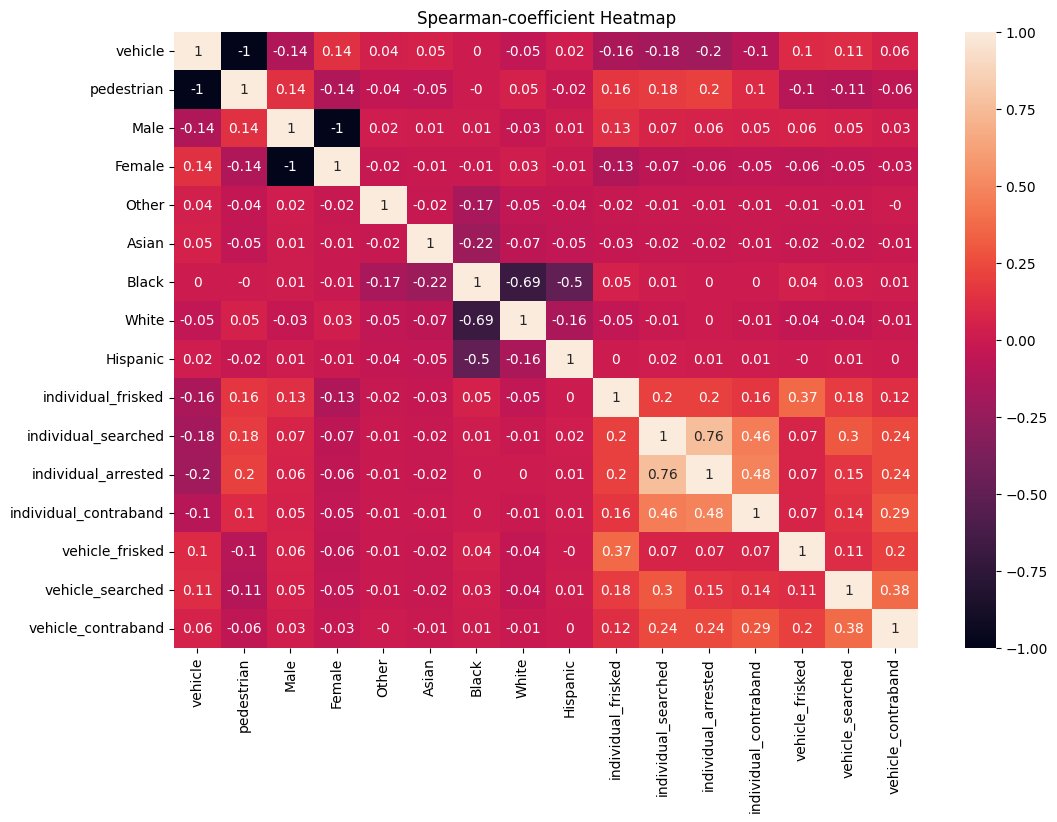

In [165]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title("Spearman-coefficient Heatmap")
sns.heatmap(np.around(hm_data.corr(method='spearman'),decimals=2), annot=True, ax = ax)

In [166]:
# using phik correlation
import phik
from phik import resources, report

In [167]:
significance_overview = hm_data.sample(10000).significance_matrix(interval_cols=hm_col)

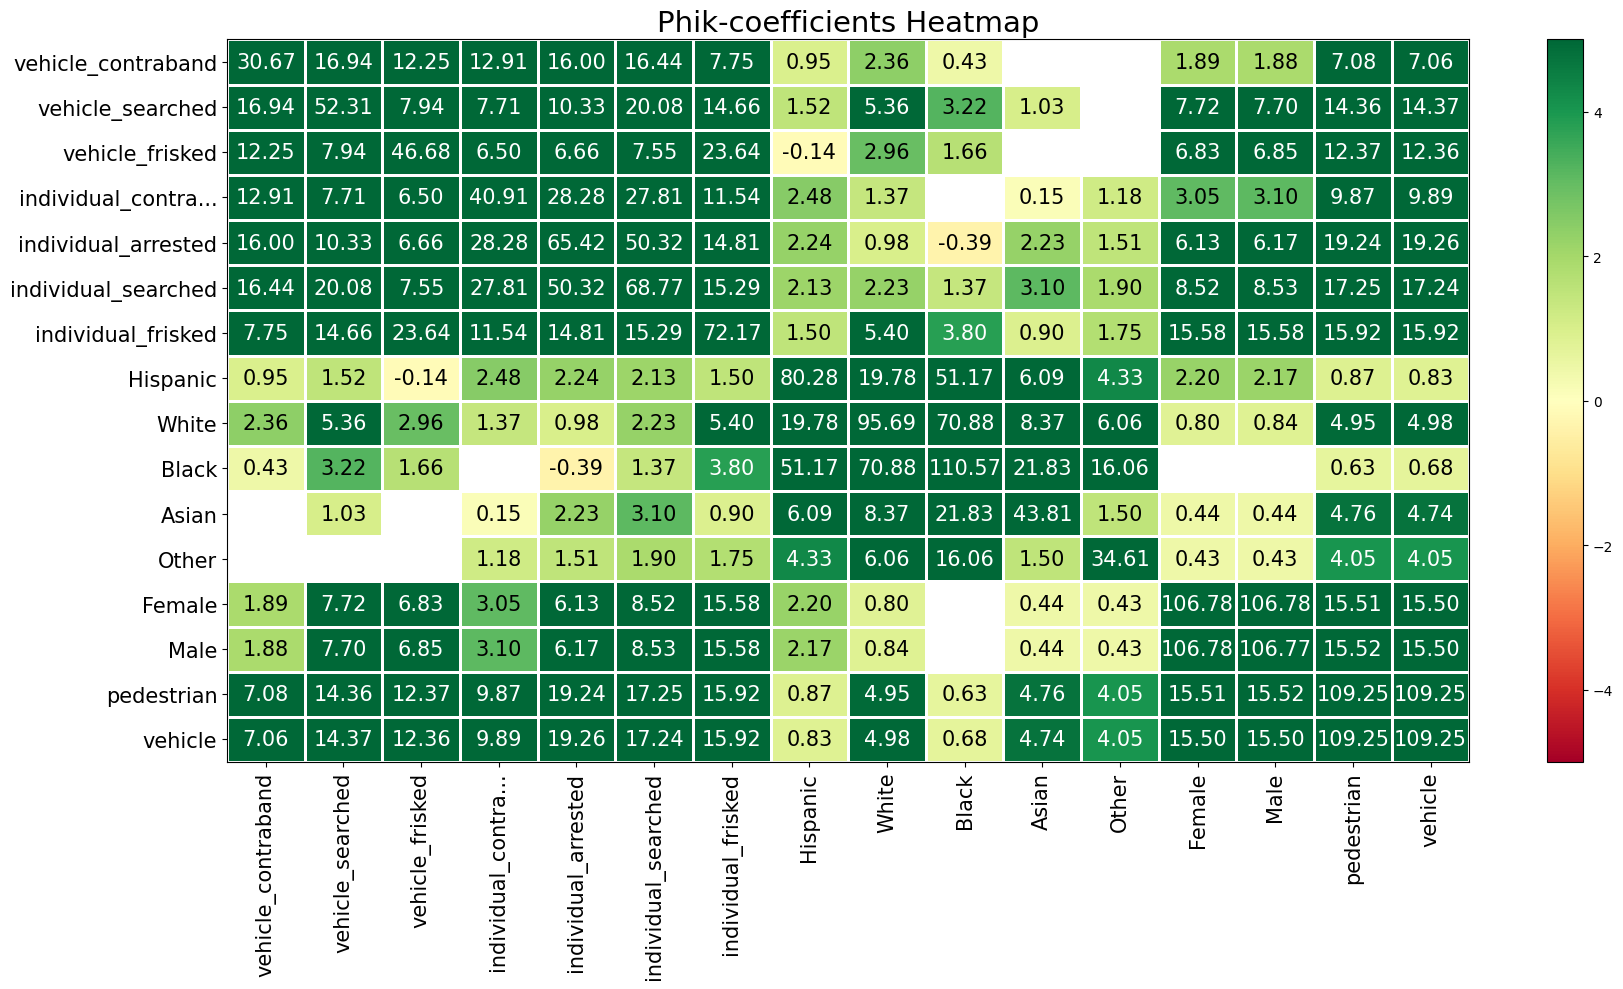

In [168]:
report.plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Phik-coefficients Heatmap", 
                        usetex=False, fontsize_factor=1.5, figsize=(18, 10))

Some observations:
- interstingly stronger correlation of male => investigation on pedestrian and female => investigation in vehicle
- there is no clear correlation of race

## Zoom into pandemic

In [169]:
mask = data['datetimeoccur'] > '2020-03-11'
pandemic = data[mask]

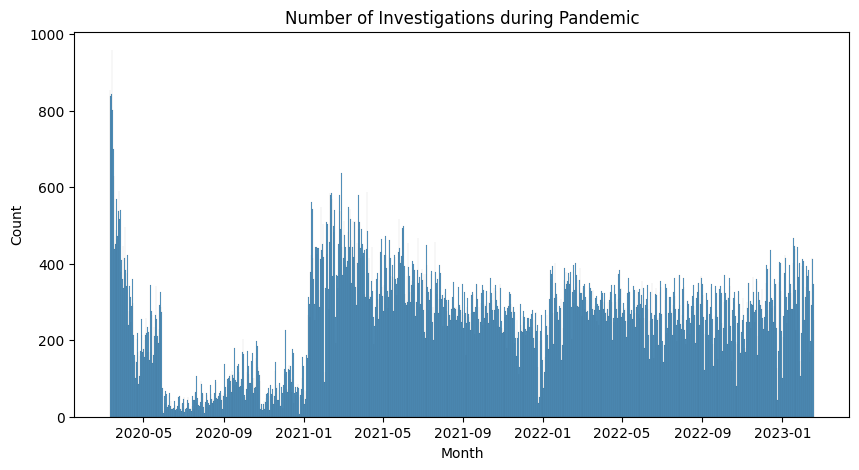

In [170]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(pandemic['datetimeoccur'].dt.date) 
ax.set_title('Number of Investigations during Pandemic')
ax.set_xlabel('Month')
plt.show()

Text(0.5, 1.0, 'Investigation by District')

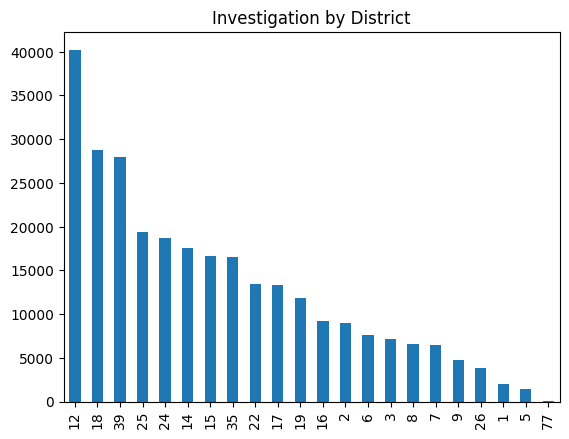

In [171]:
# investigate the patrol & investigation carried out by PSA during pandemic
ax = pandemic['districtoccur'].value_counts().plot.bar()
ax.set_title('Investigation by District')

In [172]:
# import plotly.express as px

In [173]:
# px.set_mapbox_access_token('sk.eyJ1IjoiaGFycnlrbmVlZWUiLCJhIjoiY2xnNTVxaDB0MDBhdTNnb3llcjE0cXpmZSJ9.Py_ijjr3UdcCXq9p3A1JzA')

In [174]:
# px.density_mapbox(pandemic.sample(100000), lat='lat', lon='lng', radius=10, zoom=10)

In [175]:
# !pip install plotly-geo==1.0.0
# !pip install geopandas==0.3.0
# !pip install pyshp==1.2.10
# !pip install shapely==1.6.3

In [176]:
# from urllib.request import urlopen
# import json
# with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
#     counties = json.load(response)

# import pandas as pd

# tmp = df['fips'].astype('str').str[:10]
# tmp = pd.DataFrame(tmp.value_counts().reset_index()).rename(columns = {'index':'fips', 'fips':'count'})

# import plotly.express as px

# fig = px.choropleth_mapbox(tmp, geojson=counties, locations='fips', color='count',
#                            color_continuous_scale="Viridis",
#                            mapbox_style="carto-positron",
#                            zoom=5, center = {"lat": 39, "lon": -75},
#                            opacity=0.5,
#                            labels={'count':'investigations'}
#                           )
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

## Racial profiling of Investigation (Before & After GF Incident)

In [177]:
mask = (data['datetimeoccur'] > '2000-01-01') & (data['datetimeoccur'] < '2020-05-25')
pre_gf_inv = data[mask]

mask = data['datetimeoccur'] > '2020-05-25'
post_gf_inv = data[mask]

In [178]:
# population census conducted in 2000
pop_df = pd.read_csv("./drive/MyDrive/ml-plus-msg/raw_data/Traffic, Investigations _ Other/philadelphia_population_metrics.csv")

In [179]:
pop_df['COUNT_OTHER'] = pop_df['COUNT_ALL_RACES_ETHNICITIES'] - pop_df['COUNT_ASIAN_NH'] - pop_df['COUNT_WHITE_NH'] - pop_df['COUNT_BLACK_NH'] - pop_df['COUNT_HISPANIC']

https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html 
Digits of GEOID

In [180]:
# 11 digits: census tract
pop_df['GEOGRAPHY_NAME'].astype('int').unique()[0]

42101000100

In [181]:
# 12 digits: census tract block (we take the first 11 digits to merge into census tract)
pre_gf_inv['fips'] = pre_gf_inv['fips'].astype('string').str[:11].astype('int') 
post_gf_inv['fips'] = post_gf_inv['fips'].astype('string').str[:11].astype('int')

<ipython-input-181-d68c328b7c81>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-181-d68c328b7c81>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Normaliser Function

In [182]:
df_race = ['White','Black', 'Asian', 'Hispanic', 'Other']
pop_race = ['COUNT_WHITE_NH', 'COUNT_BLACK_NH','COUNT_ASIAN_NH',
            'COUNT_HISPANIC', 'COUNT_OTHER']
map_col = {x:y for x,y in zip(df_race, pop_race)}

def get_norm_rate(df, pop_df):
  norm_df = pd.DataFrame(columns = ['fips']+df_race)

  for id in df['fips'].unique():
      tract_df = df[df['fips'] == id]
      tract_pop = pop_df[pop_df['GEOGRAPHY_NAME'] == id]
      
      new_row = {'fips':id}
      for r in df_race:
        # metric k = df entries / census tract population (GROUP BY race group)
        k = ((tract_df[r] == 1).sum())/tract_pop[map_col[r]]
        if k.size > 0 and k.values != np.nan:
          new_row[r] = [min(k.values[0], 1)]
        else:
          new_row[r] = [np.nan]
      new_row = pd.DataFrame(new_row)
      norm_df = pd.concat([norm_df, new_row], ignore_index=True)

  return norm_df

In [183]:
norm_investigation = get_norm_rate(pre_gf_inv, pop_df)
norm_investigation.dropna(inplace=True)
norm_investigation.head()

,fips,White,Black,Asian,Hispanic,Other
0,42101001101,0.005063,0.035608,0.008811,0.006173,0.042105
1,42101036700,0.761534,1.000000,1.000000,1.000000,1.000000
2,42101031401,0.860174,1.000000,0.253406,0.672377,0.434783
3,42101012500,0.871541,1.000000,0.356784,1.000000,1.000000
4,42101003600,0.177350,0.177902,0.080752,0.083851,0.054422


In [184]:
for col in df_race:
  print(col, np.mean(norm_investigation[col].values))

White 0.5640454093046144
Black 0.7872151196361044
Asian 0.5083795650881456
Hispanic 0.5385092611569294
Other 0.4736014404432165


### Investigation

In [185]:
pre_gf_inv_norm = get_norm_rate(pre_gf_inv, pop_df).dropna()
pre_gf_inv_norm.head()

,fips,White,Black,Asian,Hispanic,Other
0,42101001101,0.005063,0.035608,0.008811,0.006173,0.042105
1,42101036700,0.761534,1.000000,1.000000,1.000000,1.000000
2,42101031401,0.860174,1.000000,0.253406,0.672377,0.434783
3,42101012500,0.871541,1.000000,0.356784,1.000000,1.000000
4,42101003600,0.177350,0.177902,0.080752,0.083851,0.054422


In [186]:
post_gf_inv_norm = get_norm_rate(post_gf_inv, pop_df).dropna()
post_gf_inv_norm.head()

,fips,White,Black,Asian,Hispanic,Other
0,42101016300,0.733333,0.525346,0.023585,0.087510,0.666667
1,42101020000,0.318182,0.335984,0.037975,0.585714,0.272727
2,42101007102,1.000000,0.450477,0.684211,0.342857,0.134831
3,42101015101,0.421053,0.059732,0.166667,0.062500,0.051282
4,42101016100,0.064842,0.298969,0.007916,0.046659,0.021583


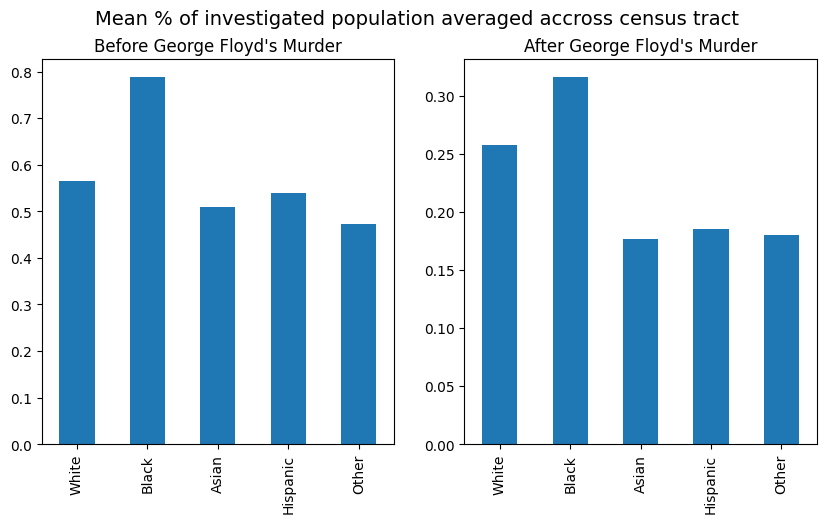

In [187]:
# normalised investigation carried out averaged accross census tract
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Mean % of investigated population averaged accross census tract", fontsize=14)
ax[0].set_title("Before George Floyd's Murder")
ax[1].set_title("After George Floyd's Murder")
pre_gf_inv_norm.drop(labels=['fips'], axis=1).mean().plot.bar(ax=ax[0])
post_gf_inv_norm.drop(labels=['fips'], axis=1).mean().plot.bar(ax=ax[1])
plt.show()

### Traffic-stop

In [188]:
path = data_root + '/Traffic, Investigations _ Other/' + 'traffic_stops_philadelphia' + '.csv'
traffic_df = pd.read_csv(path).dropna()

<ipython-input-188-67c80c9e199f>:2: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



In [189]:
traffic_df['subject_race'].unique()

array(['black', 'hispanic', 'white', 'asian/pacific islander', 'other',
       'unknown'], dtype=object)

In [190]:
traffic = pd.get_dummies(traffic_df, prefix="", prefix_sep="", columns = ['subject_race'], dtype = int)

map = {'black':'Black', 'hispanic':'Hispanic', 'white':'White', 'asian/pacific islander':'Asian'}
traffic = traffic.rename(mapper=map, axis=1)
traffic.columns

Index(['objectid', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'service_area', 'subject_age', 'subject_sex', 'type', 'arrest_made',
       'outcome', 'contraband_found', 'frisk_performed', 'search_conducted',
       'search_person', 'search_vehicle', 'raw_race',
       'raw_individual_contraband', 'raw_vehicle_contraband', 'fips', 'Asian',
       'Black', 'Hispanic', 'other', 'unknown', 'White'],
      dtype='object')

In [191]:
mask = (traffic['date'] > '2000-01-01') & (traffic['date'] < '2020-05-25')
pre_gf_tra = traffic[mask]

mask = traffic['date'] > '2020-05-25'
post_gf_tra = traffic[mask]

In [192]:
pre_gf_tra['Other'] = pre_gf_tra['other'] + pre_gf_tra['unknown']
post_gf_tra['Other'] = post_gf_tra['other'] + post_gf_tra['unknown']

In [193]:
# 12 digits: census tract block (we take the first 11 digits to merge into census tract)
pre_gf_tra['fips'] = pre_gf_tra['fips'].astype('string').str[:11].astype('int') 
post_gf_tra['fips'] = post_gf_tra['fips'].astype('string').str[:11].astype('int')

In [194]:
pre_gf_tra_norm = get_norm_rate(pre_gf_tra, pop_df)
post_gf_tra_norm = get_norm_rate(post_gf_tra, pop_df)

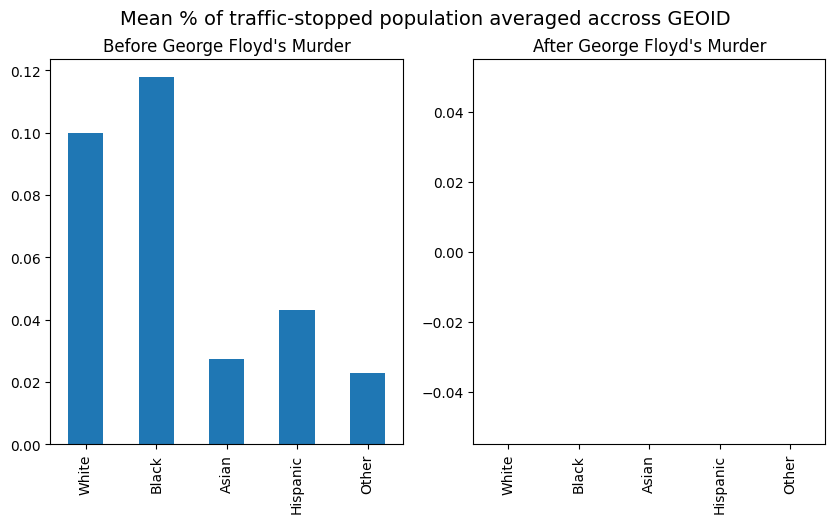

In [195]:
# normalised traffic stops carried out averaged accross GEOID
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Mean % of traffic-stopped population averaged accross GEOID", fontsize=14)
ax[0].set_title("Before George Floyd's Murder")
ax[1].set_title("After George Floyd's Murder")
pre_gf_tra_norm.drop(labels=['fips'], axis=1).mean().plot.bar(ax=ax[0])
post_gf_tra_norm.drop(labels=['fips'], axis=1).mean().plot.bar(ax=ax[1])
plt.show()

## Modes of Investigation

https://www.phillypolice.com/assets/directives/D12.8-VehicleOrPedestrianInvestigations.pdf 
While a traffic stop allows passengers to be detained during the investigation, it
does not automatically authorize an officer to frisk the driver or passengers.
Officers must have additional reasonable suspicion to believe the driver or a
passenger has a weapon that could harm the officer. The additional reasonable
suspicion must be articulated on the 75-48A every time a frisk is conducted.

In [196]:
def get_rate(df, tot_df, groupby_col):
  rate_df = pd.DataFrame(columns = ['fips']+groupby_col)

  for id in df['fips'].unique():
      tract_df = df[df['fips'] == id]
      tract_tot = tot_df[tot_df['fips'] == id]
      
      new_row = {'fips':id}
      for r in groupby_col:
        # metric k = df entries / total df entries (GROUP BY race group)
        k = ((tract_df[r] == 1).sum())/((tract_tot[r] == 1).sum())
        new_row[r] = [min(k, 1)]
        
      new_row = pd.DataFrame(new_row)
      rate_df = pd.concat([rate_df, new_row], ignore_index=True)

  return rate_df

### Pedestrian Individuals 

Now we explore the % of investigation that involved frisking for each ethinicity.

In [197]:
frisked_rate_df = get_rate(data[data['individual_frisked']==1], data[data['pedestrian']==1], df_race)

<ipython-input-196-9826e8bad518>:11: RuntimeWarning:

invalid value encountered in long_scalars

<ipython-input-196-9826e8bad518>:11: RuntimeWarning:

divide by zero encountered in long_scalars



<Axes: title={'center': 'Mean % of pedestrian investigations that involved frisking for each ethinicity'}>

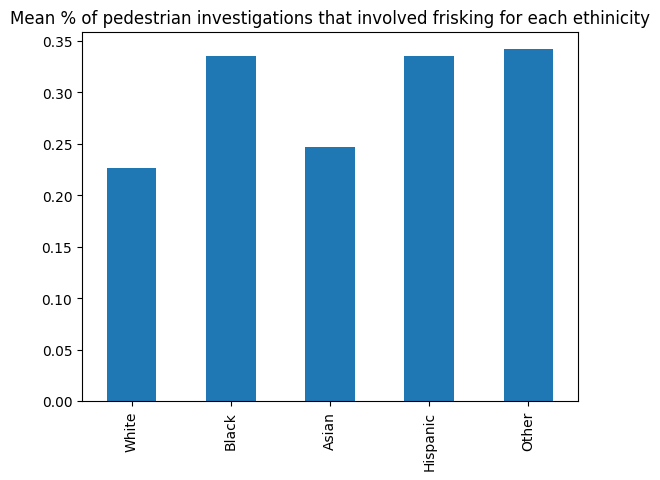

In [198]:
fig, ax = plt.subplots()
ax.set_title("Mean % of pedestrian investigations that involved frisking for each ethinicity")
frisked_rate_df.dropna().drop(columns='fips').mean().plot.bar()

In [199]:
searched_rate_df = get_rate(data[data['individual_searched']==1], data[data['pedestrian']==1], df_race)

<ipython-input-196-9826e8bad518>:11: RuntimeWarning:

invalid value encountered in long_scalars

<ipython-input-196-9826e8bad518>:11: RuntimeWarning:

divide by zero encountered in long_scalars



<Axes: title={'center': 'Mean % of pedestrian investigations that involved searching for each ethinicity'}>

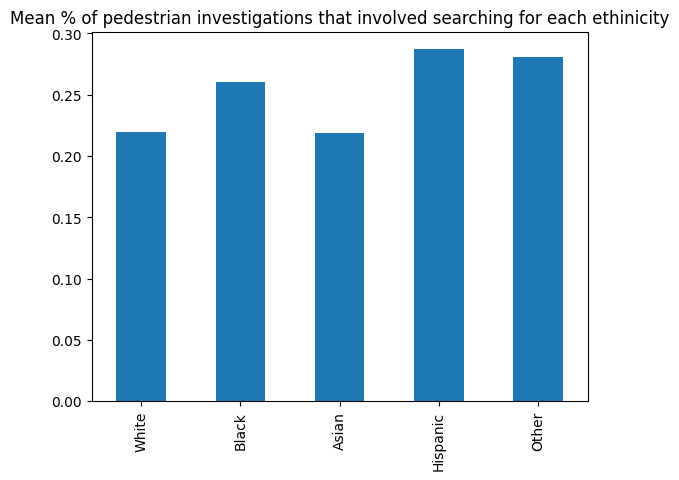

In [200]:
fig, ax = plt.subplots()
ax.set_title("Mean % of pedestrian investigations that involved searching for each ethinicity")
searched_rate_df.dropna().drop(columns='fips').mean().plot.bar()

In [201]:
arrest_rate_df = get_rate(data[data['individual_arrested']==1], data[data['pedestrian']==1], df_race)

<ipython-input-196-9826e8bad518>:11: RuntimeWarning:

invalid value encountered in long_scalars

<ipython-input-196-9826e8bad518>:11: RuntimeWarning:

divide by zero encountered in long_scalars



<Axes: title={'center': 'Mean % of pedestrian investigations that led to arrest for each ethinicity'}>

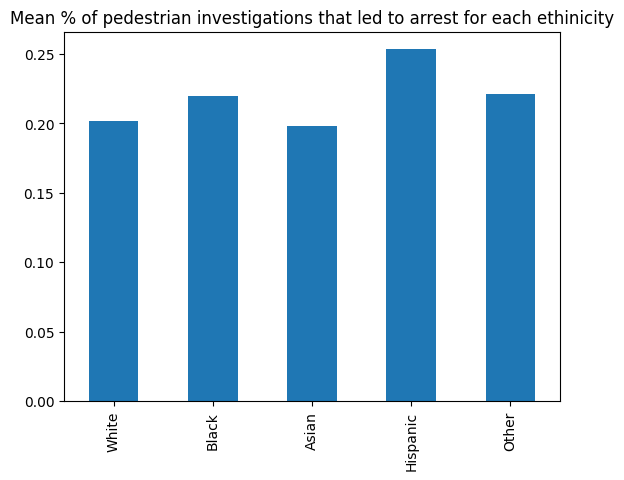

In [202]:
fig, ax = plt.subplots()
ax.set_title("Mean % of pedestrian investigations that led to arrest for each ethinicity")
arrest_rate_df.dropna().drop(columns='fips').mean().plot.bar()

### Vehicles

In [203]:
frisked_rate_df = get_rate(data[data['vehicle_frisked']==1], data[data['vehicle']==1], df_race)

<ipython-input-196-9826e8bad518>:11: RuntimeWarning:

invalid value encountered in long_scalars



<Axes: title={'center': 'Mean % of vehicle investigations that involved frisking for each ethinicity'}>

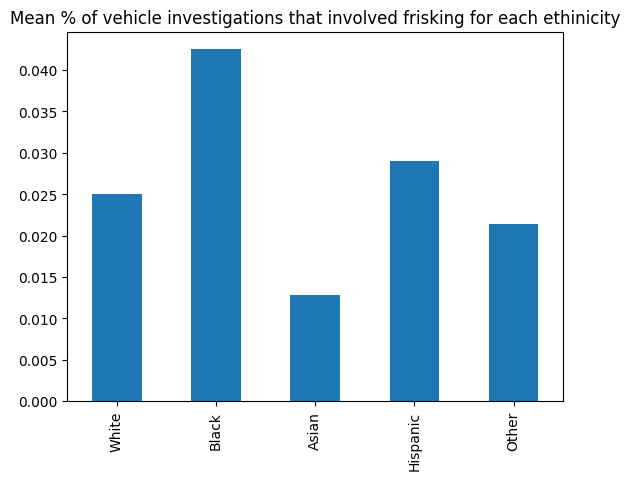

In [204]:
fig, ax = plt.subplots()
ax.set_title("Mean % of vehicle investigations that involved frisking for each ethinicity")
frisked_rate_df.dropna().drop(columns='fips').mean().plot.bar()

In [205]:
contraband_rate_df = get_rate(data[data['vehicle_contraband']==1], data[data['vehicle']==1], df_race)

<ipython-input-196-9826e8bad518>:11: RuntimeWarning:

invalid value encountered in long_scalars



<Axes: title={'center': 'Mean % of vehicle investigations that found contraband for each ethinicity'}>

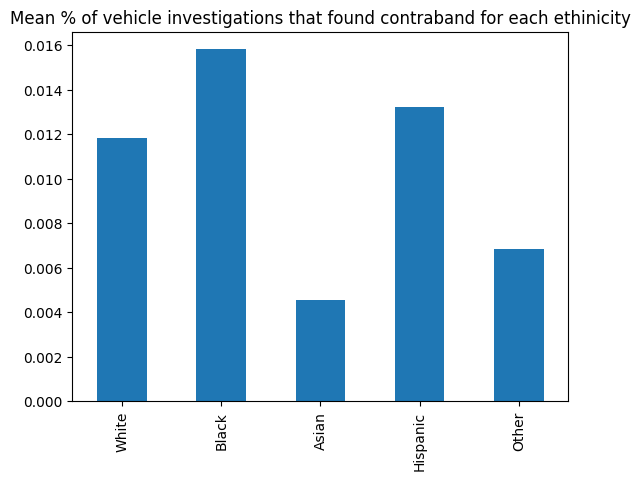

In [206]:
fig, ax = plt.subplots()
ax.set_title("Mean % of vehicle investigations that found contraband for each ethinicity")
contraband_rate_df.dropna().drop(columns='fips').mean().plot.bar()

In [207]:
arrest_rate_df = get_rate(data[data['individual_arrested']==1], data[data['vehicle']==1], df_race)

<ipython-input-196-9826e8bad518>:11: RuntimeWarning:

invalid value encountered in long_scalars

<ipython-input-196-9826e8bad518>:11: RuntimeWarning:

divide by zero encountered in long_scalars



<Axes: title={'center': 'Mean % of vehicle investigations that led to arrest for each ethinicity'}>

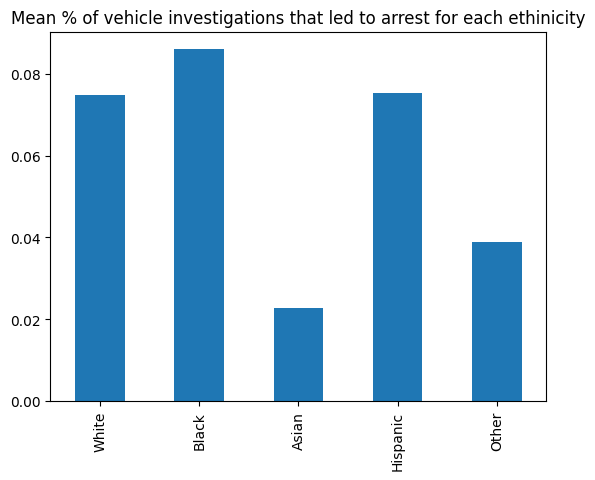

In [209]:
fig, ax = plt.subplots()
ax.set_title("Mean % of vehicle investigations that led to arrest for each ethinicity")
arrest_rate_df.dropna().drop(columns='fips').mean().plot.bar()

## Philadelphia Police Complaints

Date Range:	Five last years to previous month
Metadata Last Updated	03/24/2023

As part of the Philadelphia Police Department's (PPD) accountability processes, PPD publishes four datasets:
1. The Complaints Against Police (CAP) dataset documents the civilian complaints alleging police misconduct
2. The CAP Findings dataset provides demographic details of the police officer involved, the allegations, and the status of the PPD's Internal Affairs Division's investigation of and findings (if available) about the allegation
3. The Complainant Demographics dataset shows the race, sex, and age of each person who filed a complaint against a police officer by complaint number
4. The History dataset details the timeline by which PPD released the complaint, concluded the investigation, and determined any resulting discipline

Begininng in 2022, complaints are filed with the Civilian Police Oversight Commission, which replaced the previous Police Advisory Commission:
https://www.phila.gov/departments/citizens-police-oversight-commission/

### Demographics

In [210]:
path = data_root + '/MISC/PPD_COMPLAINANT_DEMOGRAPHICS.csv'
df = pd.read_csv(path)
df.head()

,COMPLAINT_ID,COMPLAINANT_SEX,COMPLAINANT_RACE,COMPLAINANT_AGE,OBJECTID
0,17-0001,Female,Latino,59.0,1
1,17-0002,Male,Black,28.0,2
2,17-0003,Male,Black,39.0,3
3,17-0004,Female,White,NaN,4
4,17-0005,Female,Black,41.0,5


In [211]:
df['COMPLAINANT_RACE'].unique()

array(['Latino', 'Black', 'White', 'Other', nan, 'Asian', 'Multi Ethnic',
       'Indian', 'Middle East',
       'Native Hawaiian Or Other Pacific Islande'], dtype=object)

In [212]:
df['COMPLAINANT_RACE']=df['COMPLAINANT_RACE'].replace({'Native Hawaiian Or Other Pacific Islande':'Native Hawaiian \n/Pacific Islande'})

Text(0.5, 1.0, 'Number of Complaints Against Philadelphia Police by Ethinicity')

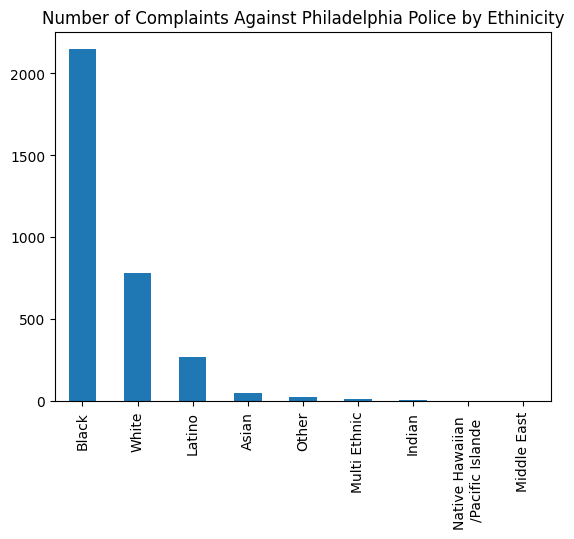

In [213]:
ax = df['COMPLAINANT_RACE'].value_counts().plot.bar()
ax.set_title("Number of Complaints Against Philadelphia Police by Ethinicity")

<Axes: xlabel='COMPLAINANT_AGE', ylabel='Count'>

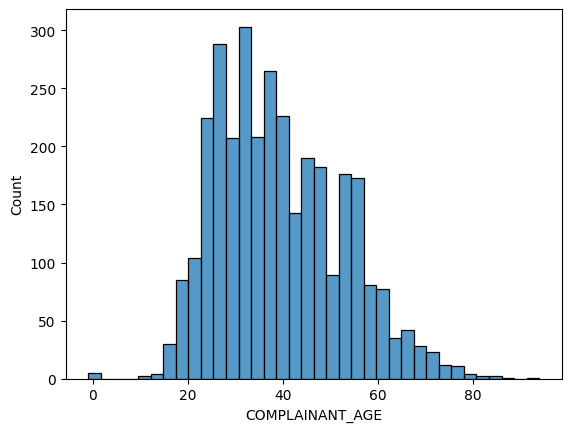

In [214]:
sns.histplot(df['COMPLAINANT_AGE'])

### Disciplines

In [215]:
path = data_root + '/MISC/PPD_COMPLAINTS_DISCIPLINES.csv'
data = pd.read_csv(path)
data.head()

,COMPLAINT_ID,OFFICER_ID,PO_RACE,PO_SEX,PO_ASSIGNED_UNIT,ALLEGATIONS_INVESTIGATED,INVESTIGATIVE_FINDINGS,DISCIPLINARY_FINDINGS,OBJECTID
0,17-0001,44679605.0,White,Male,2500 25TH DISTRICT,Unprofessional Conduct,No Sustained Findings,Not Applicable,1
1,17-0001,44679605.0,White,Male,2500 25TH DISTRICT,Criminal Allegation,No Sustained Findings,Not Applicable,2
2,17-0002,22122270.0,Black,Female,1800 18TH DISTRICT,Lack of Service,Sustained Finding,Training/Counseling,3
3,17-0002,86228181.0,Black,Male,1800 18TH DISTRICT,Lack of Service,No Sustained Findings,Not Applicable,4
4,17-0002,32815400.0,Latino,Male,1800 18TH DISTRICT,Lack of Service,Sustained Finding,Training/Counseling,5


Text(0.5, 1.0, 'Number of Police Officer received Complaints by Ethinicity')

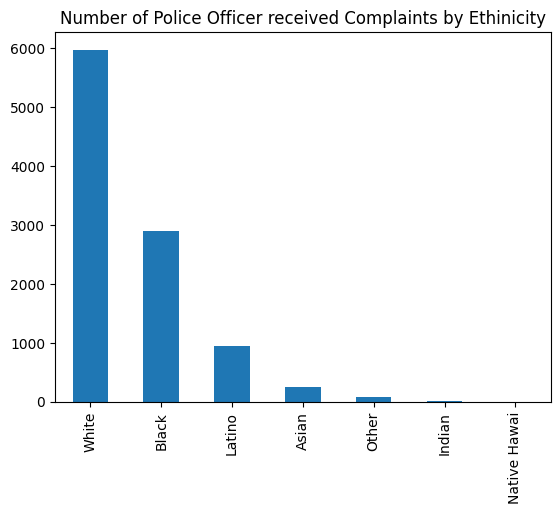

In [216]:
ax = data['PO_RACE'].value_counts().plot.bar()
ax.set_title("Number of Police Officer received Complaints by Ethinicity")

In [217]:
df.size

19985

In [218]:
data.size

96264

In [219]:
len(np.intersect1d(df['COMPLAINT_ID'].values, data['COMPLAINT_ID'].values))

3704

In [220]:
complaints = np.intersect1d(df['COMPLAINT_ID'].values, data['COMPLAINT_ID'].values)

In [221]:
new_df = pd.DataFrame()
for c in complaints:
  df[df['COMPLAINT_ID'] == c]